# Modèle linéaire

# Dépendences

In [1]:
%pip install control

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import control as ct
import pandas as pd
from scipy.io import loadmat

## Speed data

In [3]:
data = loadmat("./Linear/SPEED.mat", squeeze_me=True, struct_as_record=False)

mydata = data['speed']
t = np.array(mydata.time).squeeze()
y = np.array(mydata.signals.values).squeeze()

# Export CSV
df = pd.DataFrame({'Time': t, 'Value': y})
df.to_csv('./Linear/export_scope.csv', index=False)

## Echelon Data

In [4]:
data = loadmat("./Linear/echelon.mat")

y = data['echelon']

df = pd.DataFrame(y)
df.to_csv("./Linear/echelon.csv", index=False)

In [5]:
output = pd.read_csv('/content/Linear/export_scope.csv')
time_step = pd.read_csv('/content/Linear/echelon.csv')
time = output['Time']
value = output["Value"]

In [6]:
Te = 0.01

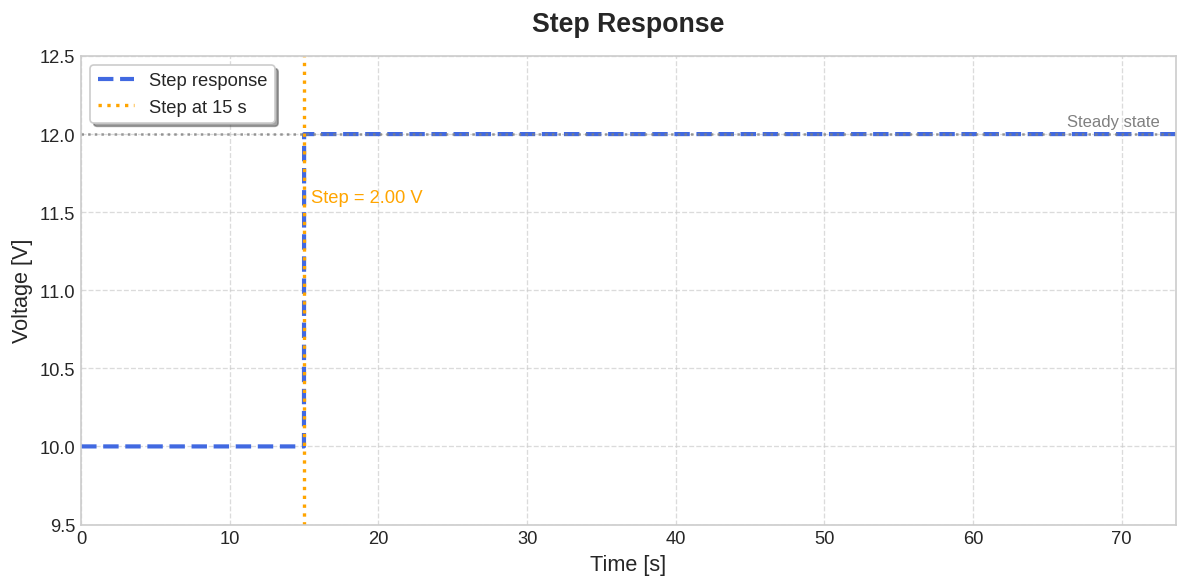

In [7]:
plt.figure(figsize=(10, 5), dpi=120)
plt.style.use('seaborn-v0_8-whitegrid')

# Use the correct time variable from the output DataFrame
time_data = output['Time']

# === Plot step response ===
plt.plot(time_data, time_step.squeeze(), color='royalblue', linestyle='--', linewidth=2.5,
         label='Step response')

# === Beautify axes ===
plt.title("Step Response", fontsize=16, fontweight='bold', pad=15)
plt.xlabel("Time [s]", fontsize=13)
plt.ylabel("Voltage [V]", fontsize=13)

# Add annotation for step time (optional)
step_index = np.argmax(np.diff(time_step.squeeze()))  # index of step change
if step_index > 0:
    step_time = time_data[step_index] # Use time_data
    plt.axvline(step_time, color='orange', linestyle=':', linewidth=2,
                label=f"Step at 15 s")
    plt.text(step_time + 0.5, np.mean(time_step.squeeze()),
             f'Step = {time_step.squeeze()[step_index+1]-time_step.squeeze()[step_index]:.2f} V',
             color='orange', fontsize=11, va='center')

# === Axis limits and ticks ===
plt.xlim([min(time_data), max(time_data)]) # Use time_data
plt.ylim([min(time_step.squeeze()) - 0.5, max(time_step.squeeze()) + 0.5])
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

# === Legend and grid ===
plt.legend(fontsize=11, loc='best', frameon=True, shadow=True)
plt.grid(True, which='major', linestyle='--', alpha=0.7)

# === Optional: add a horizontal steady-state line ===
plt.axhline(max(time_step.squeeze()), color='gray', linestyle=':', linewidth=1.5, alpha=0.8)
plt.text(time_data.iloc[-1]*0.9, max(time_step.squeeze())+0.05, "Steady state", fontsize=10, color='gray') # Use time_data.iloc[-1]

# === Tight layout and show ===
plt.tight_layout()
plt.show()

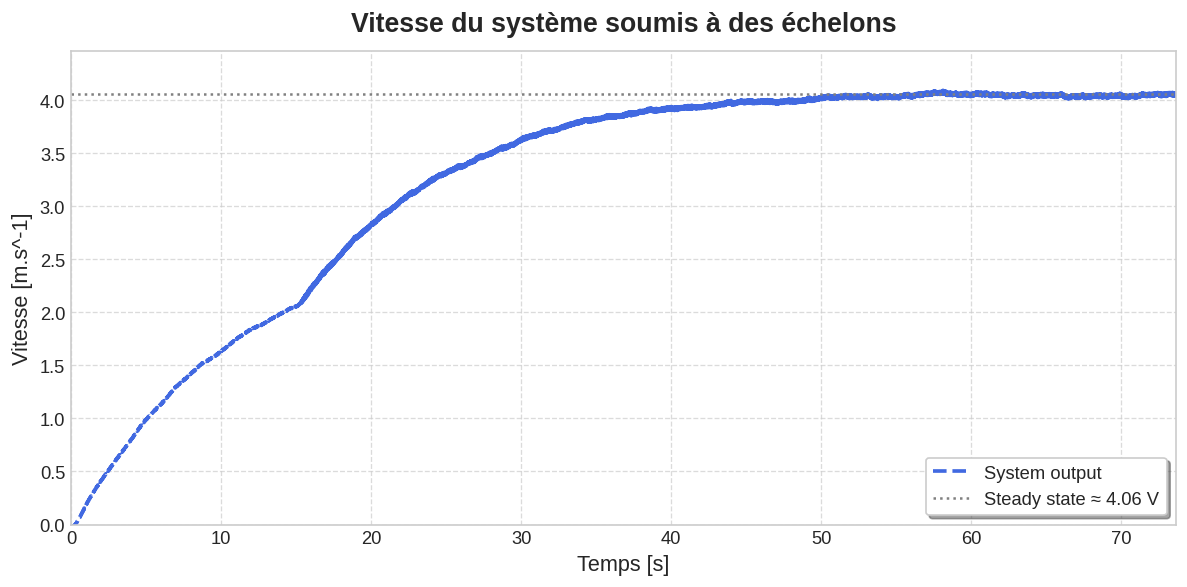

In [8]:
# === Create a figure with nice style ===
plt.figure(figsize=(10, 5), dpi=120)
plt.style.use('seaborn-v0_8-whitegrid')

# Use the correct time and value variables from the output DataFrame
time_data = output['Time']
value_data = output['Value']

# === Plot step response ===
plt.plot(time_data, value_data, color='royalblue', linestyle='--', linewidth=2.2, label='System output')

# === Compute key characteristics (optional) ===
steady_state = np.mean(value_data[-50:])       # average of last points

# === Annotate steady-state and rise time ===
plt.axhline(steady_state, color='gray', linestyle=':', linewidth=1.5, label=f"Steady state ≈ {steady_state:.2f} V")

# === Titles and axis labels ===
plt.title("Vitesse du système soumis à des échelons", fontsize=16, fontweight='bold', pad=12)
plt.xlabel("Temps [s]", fontsize=13)
plt.ylabel("Vitesse [m.s^-1]", fontsize=13)

# === Axes formatting ===
plt.xlim(min(time_data), max(time_data))
plt.ylim(0, steady_state * 1.1)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

# === Legend and grid ===
plt.legend(fontsize=11, loc='best', frameon=True, shadow=True)
plt.grid(True, which='major', linestyle='--', alpha=0.7)

# === Finishing touches ===
plt.tight_layout()
plt.show()

In [9]:
index = int(15/Te)
value_cropped = value[index:]
time_cropped = time[index:]
time_step_cropped = time_step[index:]

In [10]:
time_translated = time_cropped - time_cropped.iloc[0]
value_translated = value_cropped - value_cropped.iloc[0]
time_step_translated = time_step_cropped - time_step_cropped.iloc[0]

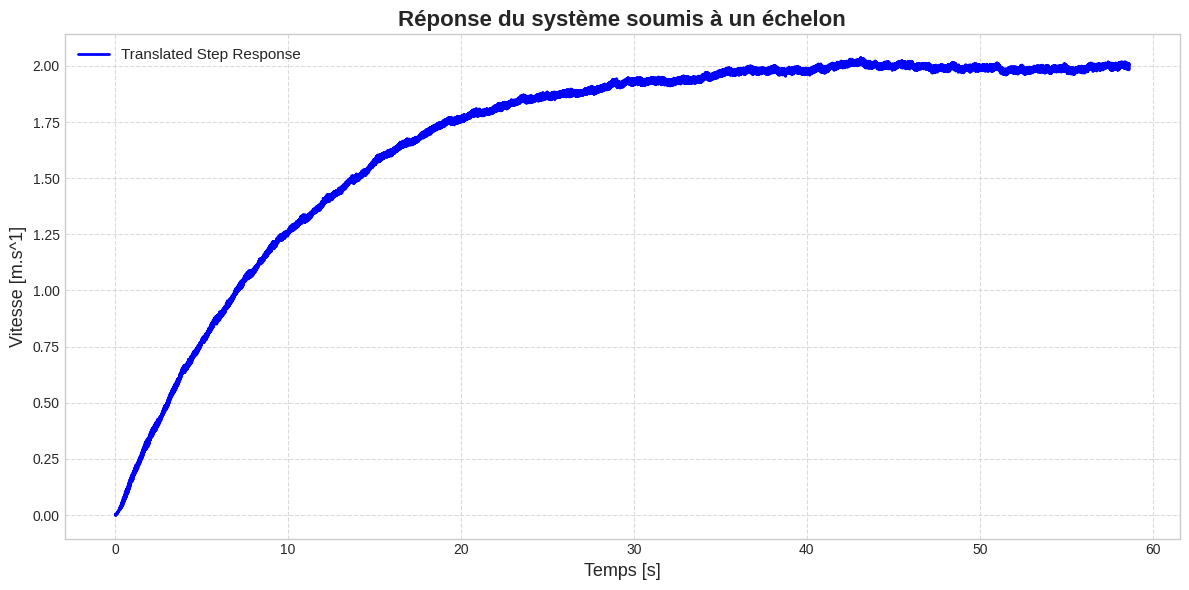

In [11]:
plt.figure(figsize=(12, 6))
plt.style.use('seaborn-v0_8-whitegrid') # Use a nice style
plt.plot(time_translated, value_translated, color='blue', linestyle='-', linewidth=2, label='Translated Step Response') # Changed color and added label
plt.xlabel('Temps [s]', fontsize=13) # Added units and increased font size
plt.ylabel('Vitesse [m.s^1]', fontsize=13) # More descriptive label and increased font size
plt.title('Réponse du système soumis à un échelon', fontsize=16, fontweight='bold') # Added a title
plt.legend(fontsize=11) # Added a legend
plt.grid(True, which='major', linestyle='--', alpha=0.7) # Improved grid
plt.tight_layout() # Adjust layout
plt.show()

In [12]:
X = np.column_stack((value_translated[:-1], np.ones(len(value_translated) - 1)))
y = value_translated[1:]

In [13]:
# Perform the least squares estimation
theta_ls = np.linalg.lstsq(X, y, rcond=None)[0]

In [14]:
theta_ls

array([0.99828086, 0.00321478])

In [15]:
alpha = theta_ls[0]
beta = theta_ls[1]

In [16]:
d = d_opt if 'd_opt' in globals() else 0

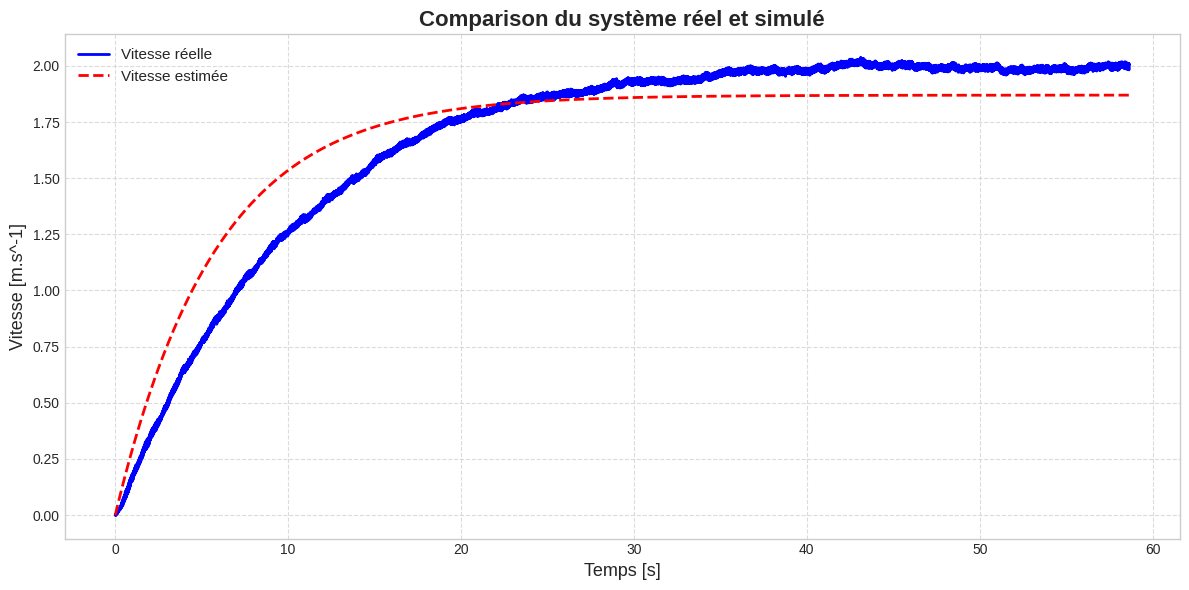

In [17]:
estimated_num = [0]*d + [beta]  # β z^{-1} * z^{-d}
estimated_den = [1, -alpha]     # 1 - α z^{-1}
H_estimated   = ct.tf(estimated_num, estimated_den, Te)

# Use the translated time vector for the model's step response
step_response_estimated = ct.step_response(H_estimated, timepts=time_translated)
output_model = step_response_estimated.outputs

# Plot the translated original data and the estimated model step response
plt.figure(figsize=(12, 6))
plt.style.use('seaborn-v0_8-whitegrid') # Use a nice style
plt.plot(time_translated, value_translated, label='Vitesse réelle', color='blue', linewidth=2) # Added linewidth
plt.plot(time_translated, output_model, label='Vitesse estimée', color='red', linestyle='--', linewidth=2) # Changed linestyle and added linewidth
plt.xlabel('Temps [s]', fontsize=13) # Added units and increased font size
plt.ylabel('Vitesse [m.s^-1]', fontsize=13) # Added units and increased font size
plt.title('Comparison du système réel et simulé', fontsize=16, fontweight='bold') # More descriptive title
plt.legend(fontsize=11) # Added a legend
plt.grid(True, which='major', linestyle='--', alpha=0.7) # Improved grid
plt.tight_layout() # Adjust layout
plt.show()

We are going to try a simpler approach

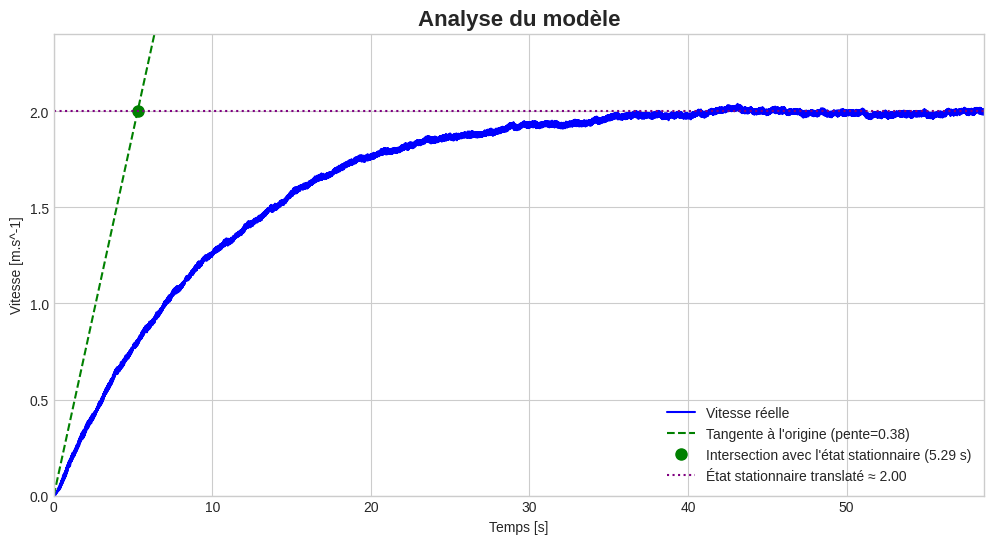

In [18]:
# Calculate the derivative at the origin (first few points)
# Using a simple forward difference
derivative_at_origin = (value_translated.iloc[1] - value_translated.iloc[0]) / (time_translated.iloc[1] - time_translated.iloc[0])

# Calculate the equation of the tangent line at the origin
# y = m*x + c, where m is the derivative and c is the initial value (0 in this case)
tangent_line = derivative_at_origin * time_translated

# Find the intersection with the steady state
# steady_state_value = derivative_at_origin * intersection_time
# intersection_time = steady_state_value / derivative_at_origin

# Calculate the steady state of the translated data
steady_state_translated = np.mean(value_translated[-50:])
intersection_time = steady_state_translated / derivative_at_origin
intersection_point_y = steady_state_translated


# Plot the translated original data and the estimated model step response
plt.figure(figsize=(12, 6))
plt.style.use('seaborn-v0_8-whitegrid') # Use a nice style
plt.plot(time_translated, value_translated, label='Vitesse réelle', color='blue') # Translated label
# plt.plot(time_translated, output_model, label='Réponse du modèle estimé', color='red') # Translated label

# Plot the tangent line at the origin
plt.plot(time_translated, tangent_line, label=f'Tangente à l\'origine (pente={derivative_at_origin:.2f})', color='green', linestyle='--') # Translated label

# Plot the intersection point with the steady state
plt.plot(intersection_time, intersection_point_y, 'go', markersize=8, label=f'Intersection avec l\'état stationnaire ({intersection_time:.2f} s)') # Translated label
plt.axhline(steady_state_translated, color='purple', linestyle=':', linewidth=1.5, label=f"État stationnaire translaté ≈ {steady_state_translated:.2f}") # Translated label


plt.xlabel('Temps [s]') # Translated label and added units
plt.ylabel('Vitesse [m.s^-1]') # Translated label and added units
plt.title('Analyse du modèle', fontsize=16, fontweight='bold') # Translated title
plt.legend() # Added a legend
plt.grid(True)
plt.xlim([0, time_translated.max()]) # Limit x-axis to see the relevant part
plt.ylim([0, steady_state_translated * 1.2]) # Adjust y-axis limit
plt.show()

H = \frac{2}{10s+1}

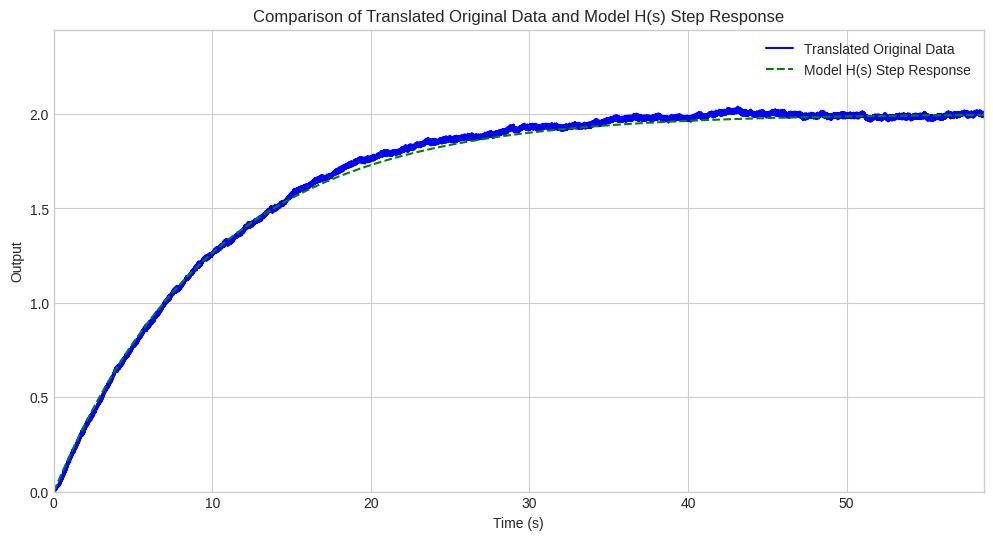

In [19]:
# Define the continuous-time transfer function
num = [2]
den = [10, 1]
H_continuous = ct.tf(num, den)

# Calculate the step response of the continuous-time model
# Use the translated time vector for the simulation
time_for_sim = time_translated.values.flatten() # control requires numpy array
t_sim, y_sim = ct.step_response(H_continuous, T=time_for_sim)


# Plot the translated original data and the estimated model step response
plt.figure(figsize=(12, 6))
plt.plot(time_translated, value_translated, label='Translated Original Data', color='blue')
plt.plot(t_sim, y_sim, label='Model H(s) Step Response', color='green', linestyle='--')


plt.xlabel('Time (s)')
plt.ylabel('Output')
plt.title('Comparison of Translated Original Data and Model H(s) Step Response')
plt.legend()
plt.grid(True)
plt.xlim([0, time_translated.max()])
plt.ylim([0, value_translated.max() * 1.2])
plt.show()

# Non linéaire - RNN

In [20]:
import os

nonlinear_dir = "./Non-linear"
vitesse_files = [f for f in os.listdir(nonlinear_dir) if f.startswith("vitesse_simulee") and f.endswith(".csv")]
db_u_files = [f for f in os.listdir(nonlinear_dir) if f.startswith("db_u") and f.endswith(".csv")]

# Sort files to ensure consistent order
vitesse_files.sort()
db_u_files.sort()

# Separate data for training (first 6 files) and testing (7th file)
train_speed_data = []
train_input_data_dfs = []
test_speed_data = None
test_input_data_df = None

for i, (vitesse_file, db_u_file) in enumerate(zip(vitesse_files, db_u_files)):
    vitesse_df = pd.read_csv(os.path.join(nonlinear_dir, vitesse_file))
    db_u_df = pd.read_csv(os.path.join(nonlinear_dir, db_u_file), header=None)

    if i < 6:
        train_speed_data.append(vitesse_df)
        train_input_data_dfs.append(db_u_df)
    else:
        test_speed_data = vitesse_df
        test_input_data_df = db_u_df


# Concatenate training data
all_train_speed_values = pd.concat([df.iloc[:, 1] for df in train_speed_data], ignore_index=True)
all_train_input_values = pd.concat(train_input_data_dfs, axis=1).stack().reset_index(drop=True)

# Test data (from the 7th file)
all_test_speed_values = test_speed_data.iloc[:, 1]
all_test_input_values = test_input_data_df.stack().reset_index(drop=True)


# Display some of the loaded data for verification
print("First training speed data file (head):")
display(train_speed_data[0].head())

print("\nFirst training input data file (head):")
display(train_input_data_dfs[0].head())

print("\nConcatenated training speed data (head):")
display(all_train_speed_values.head())

print("\nConcatenated training input data (head):")
display(all_train_input_values.head())

print("\nTest speed data (head):")
display(all_test_speed_values.head())

print("\nTest input data (head):")
display(all_test_input_values.head())

First training speed data file (head):


,0,-0.0220543100310755
0,0.1,-0.025317
1,0.2,-0.027927
2,0.3,-0.040063
3,0.4,-0.055071
4,0.5,-0.067076



First training input data file (head):


,0,1,2,3,4,5,6,7,8,9,...,991,992,993,994,995,996,997,998,999,1000
0,-10.00462,-10.00462,-10.00462,-10.00462,-10.00462,-10.00462,-10.00462,-10.00462,-10.00462,-10.00462,...,4.67953,4.67953,4.67953,4.67953,4.67953,4.67953,4.67953,4.67953,4.67953,NaN



Concatenated training speed data (head):


,0
0,-0.025317
1,-0.027927
2,-0.040063
3,-0.055071
4,-0.067076



Concatenated training input data (head):


,0
0,-10.00462
1,-10.00462
2,-10.00462
3,-10.00462
4,-10.00462



Test speed data (head):


,-0.021662813403305
0,-0.016704
1,0.008874
2,0.052722
3,0.108706
4,0.191833



Test input data (head):


,0
0,15.67579
1,15.67579
2,15.67579
3,15.67579
4,15.67579


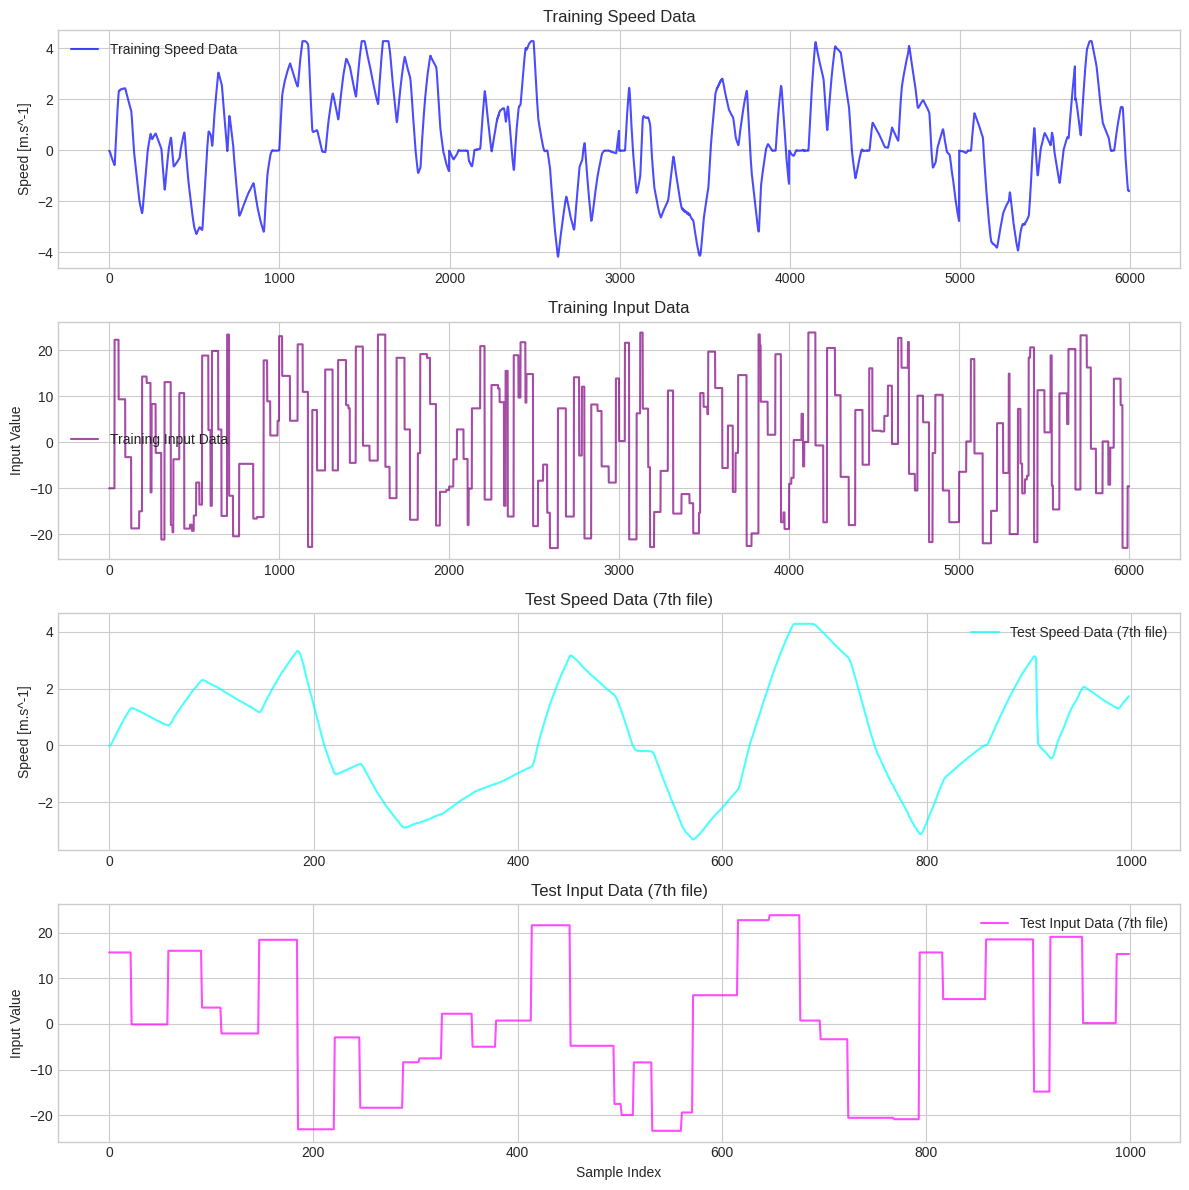

In [21]:
plt.figure(figsize=(12, 12)) # Increased figure size for four subplots
plt.style.use('seaborn-v0_8-whitegrid')

# Plot training speed data
plt.subplot(4, 1, 1) # 4 rows, 1 column, 1st plot
plt.plot(all_train_speed_values, label='Training Speed Data', color='blue', alpha=0.7)
plt.ylabel('Speed [m.s^-1]')
plt.title('Training Speed Data') # Specific title
plt.legend()
plt.grid(True)

# Plot training input data
plt.subplot(4, 1, 2) # 4 rows, 1 column, 2nd plot
plt.plot(all_train_input_values, label='Training Input Data', color='purple', alpha=0.7)
plt.ylabel('Input Value')
plt.title('Training Input Data') # Specific title
plt.legend()
plt.grid(True)

# Plot test speed data
plt.subplot(4, 1, 3) # 4 rows, 1 column, 3rd plot
plt.plot(all_test_speed_values, label='Test Speed Data (7th file)', color='cyan', alpha=0.7)
plt.ylabel('Speed [m.s^-1]')
plt.title('Test Speed Data (7th file)') # Specific title
plt.legend()
plt.grid(True)

# Plot test input data
plt.subplot(4, 1, 4) # 4 rows, 1 column, 4th plot
plt.plot(all_test_input_values, label='Test Input Data (7th file)', color='magenta', alpha=0.7)
plt.xlabel('Sample Index')
plt.ylabel('Input Value')
plt.title('Test Input Data (7th file)') # Specific title
plt.legend()
plt.grid(True)

plt.tight_layout() # Adjust layout
plt.show()

Truncated training data length: 5994
Truncated testing data length: 999
Shape of X_train after reshaping for LSTM: (5994, 1, 1)
Shape of y_train: (5994, 1)
Shape of X_test after reshaping for LSTM: (999, 1, 1)
Shape of y_test: (999, 1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.2843 - val_loss: 0.0416
Epoch 2/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0485 - val_loss: 0.0423
Epoch 3/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0438 - val_loss: 0.0421
Epoch 4/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0459 - val_loss: 0.0420
Epoch 5/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0446 - val_loss: 0.0424
Epoch 6/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0437 - val_loss: 0.0434
Epoch 7/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0438 - val_loss: 0.0419
Epoch 8/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0452 - val_loss: 0.0434
Epoch 9/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0448 - val_loss: 0.0435
Epoch 10/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0443 - val_loss: 0.0428
Epoch 11/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0452 - val_loss: 0.0426
Epoch 12/100
150/150 ━━━━━━━━━━━━━━━━━━━

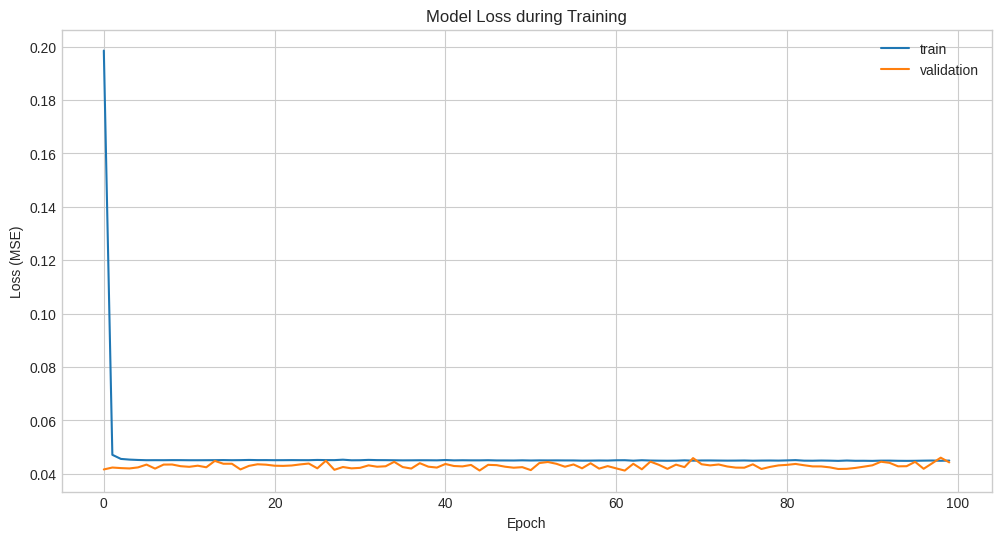

In [22]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Ensure all_train_speed_values, all_train_input_values, all_test_speed_values, and all_test_input_values are available

# 1. Normalize data
speed_scaler = MinMaxScaler()
normalized_train_speed = speed_scaler.fit_transform(all_train_speed_values.values.reshape(-1, 1))
normalized_test_speed = speed_scaler.transform(all_test_speed_values.values.reshape(-1, 1))


input_scaler = MinMaxScaler()
normalized_train_input = input_scaler.fit_transform(all_train_input_values.values.reshape(-1, 1)) # Normalize concatenated training input values
normalized_test_input = input_scaler.transform(all_test_input_values.values.reshape(-1, 1)) # Normalize concatenated testing input values


# 2. Prepare data for LSTM (create sequences)
# We need to predict the current speed value (y) based on the current input (X).
# X will be [current_input]
# y will be [current_speed]

# Ensure lengths match for training data
if len(normalized_train_input) != len(normalized_train_speed):
    print("Warning: Length of normalized training input and speed data do not match. Truncating.")
    min_train_len = min(len(normalized_train_input), len(normalized_train_speed))
    normalized_train_input = normalized_train_input[:min_train_len]
    normalized_train_speed = normalized_train_speed[:min_train_len]
    print(f"Truncated training data length: {min_train_len}")

# Ensure lengths match for testing data
if len(normalized_test_input) != len(normalized_test_speed):
    print("Warning: Length of normalized testing input and speed data do not match. Truncating.")
    min_test_len = min(len(normalized_test_input), len(normalized_test_speed))
    normalized_test_input = normalized_test_input[:min_test_len]
    normalized_test_speed = normalized_test_speed[:min_test_len]
    print(f"Truncated testing data length: {min_test_len}")


# For LSTM, we typically structure data as [samples, time_steps, features]
# With sequence_length = 1, time_steps = 1
# Features will be [normalized_input]

X_train = normalized_train_input # Features: current input
y_train = normalized_train_speed # Target: current speed

X_test = normalized_test_input # Features: current input
y_test = normalized_test_speed # Target: current speed


# Reshape X_train and X_test for LSTM: [samples, time_steps, features]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))


print("Shape of X_train after reshaping for LSTM:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test after reshaping for LSTM:", X_test.shape)
print("Shape of y_test:", y_test.shape)


# 3. Build the LSTM model
model = Sequential()
# Input shape is now (time_steps, features) = (1, 1) as we only have one input feature
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]))) # 50 LSTM units
model.add(Dense(1)) # Output layer with 1 unit for predicting speed

model.compile(optimizer='adam', loss='mse') # Using Adam optimizer and Mean Squared Error loss

# 4. Train the model
history = model.fit(X_train, y_train, epochs=100, validation_split=0.2, verbose=1) # Train for 100 epochs, 20% of training data used for validation

# 5. Plot training history (optional)
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Model Loss during Training')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

Truncated test data length: 999
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Mean Squared Error on Test Set (7th file): 3.6738


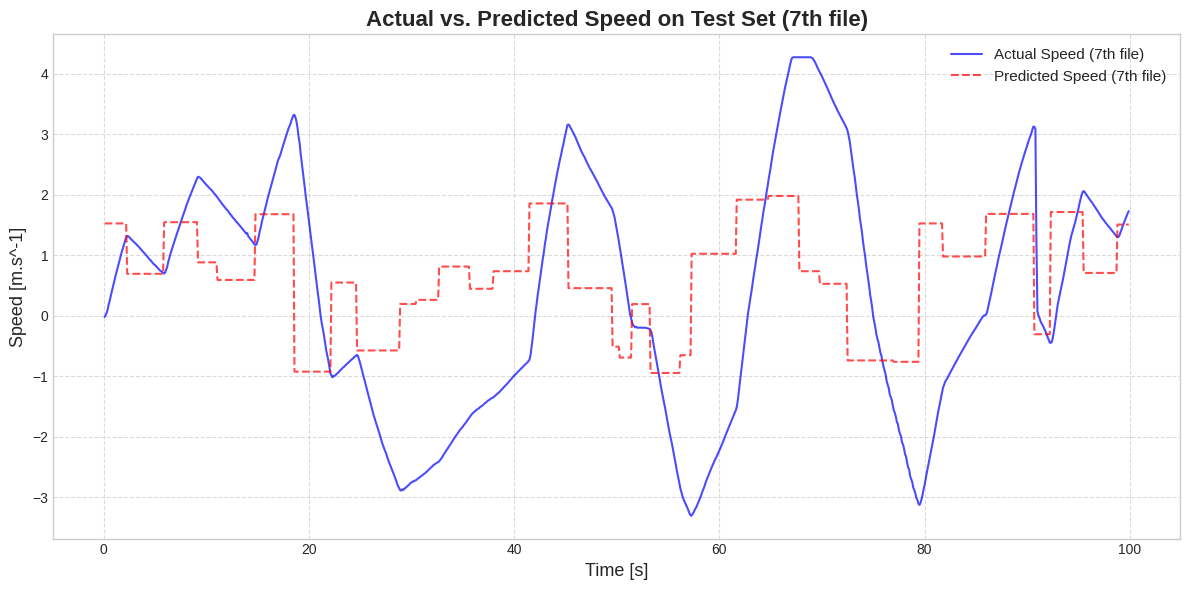

In [23]:
from sklearn.metrics import mean_squared_error

# Prepare the test data for prediction
# We need to create input features (X_test) and target values (y_test)
# from the test data (all_test_input_values, all_test_speed_values)
# similar to how we prepared the training data.

# Ensure lengths match for creating input-output pairs for the test set
if len(all_test_input_values) != len(all_test_speed_values):
    print("Warning: Length of test input and speed data do not match. Truncating.")
    min_test_len = min(len(all_test_input_values), len(all_test_speed_values))
    all_test_input_values = all_test_input_values[:min_test_len]
    all_test_speed_values = all_test_speed_values[:min_test_len]
    print(f"Truncated test data length: {min_test_len}")


# Normalize the test data using the scalers fitted on the training data
normalized_test_input = input_scaler.transform(all_test_input_values.values.reshape(-1, 1))
normalized_test_speed = speed_scaler.transform(all_test_speed_values.values.reshape(-1, 1))


# Create input features (X_test) and target values (y_test) for the test set
# X_test will be [current_input] - Modified to use only current input
# y_test will be [current_speed] (next speed)
# We also need to align the length of X_test and y_test
min_len_test_prepared = min(len(normalized_test_input), len(normalized_test_speed))
X_test_prepared = normalized_test_input[:min_len_test_prepared] # Using only current input
y_test_prepared = normalized_test_speed[:min_len_test_prepared] # Corresponding speed values


# Reshape X_test for LSTM: [samples, time_steps, features]
# time_steps = 1, features = 1
X_test_reshaped = X_test_prepared.reshape((X_test_prepared.shape[0], 1, X_test_prepared.shape[1]))


# Evaluate the model on the test set
# Make predictions on the prepared and reshaped test set
y_pred_normalized = model.predict(X_test_reshaped)

# Inverse transform the predictions and actual values back to original scale
y_pred = speed_scaler.inverse_transform(y_pred_normalized)
y_test_original = speed_scaler.inverse_transform(y_test_prepared) # Use y_test_prepared here


# Calculate Mean Squared Error
mse = mean_squared_error(y_test_original, y_pred)
print(f"Mean Squared Error on Test Set (7th file): {mse:.4f}")

# Plotting the test set results
plt.figure(figsize=(12, 6))
plt.style.use('seaborn-v0_8-whitegrid')

# Since we are plotting the prediction of the 7th file, we can use its original time vector if available
# Assuming the time vector for the 7th file is in test_speed_data.iloc[:, 0] and has the same length as the speed data
# We need to align the time vector with the prepared test data length
test_time = test_speed_data.iloc[:len(y_test_original), 0].reset_index(drop=True) # Align time with the length of y_test_original


plt.plot(test_time, y_test_original, label='Actual Speed (7th file)', color='blue', alpha=0.7)
plt.plot(test_time, y_pred, label='Predicted Speed (7th file)', color='red', linestyle='--', alpha=0.7)

plt.title('Actual vs. Predicted Speed on Test Set (7th file)', fontsize=16, fontweight='bold')
plt.xlabel('Time [s]', fontsize=13) # Use time as x-axis
plt.ylabel('Speed [m.s^-1]', fontsize=13)
plt.legend(fontsize=11)
plt.grid(True, which='major', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()